In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# Step 1: Data Preparation

In [2]:
def read_csv_file(file_path):
    return pd.read_csv(file_path)

In [6]:
import chardet

file_path = 'OnlineRetail.csv'  # Replace 'OnlineRetail.csv' with the path to your CSV file

# Read the file in binary mode and detect the encoding
with open(file_path, 'rb') as f:
    result = chardet.detect(f.read())

# Retrieve the detected encoding
encoding = result['encoding']

# Read the CSV file with the detected encoding
df = pd.read_csv(file_path, encoding=encoding)
print(df)

       InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

            InvoiceDate  UnitPrice  CustomerID         Country  
0        1

In [7]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [8]:
df.shape

(541909, 8)

In [9]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [10]:
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [11]:
df.drop(["Country"], axis=1, inplace=True)

In [12]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0
...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0


# Step 2: Feature Engineering

In [13]:
# Convert 'InvoiceDate' to a datetime object for date-based calculations
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [14]:
# Calculate the total spending for each transaction
df['TotalSpending'] = df['Quantity'] * df['UnitPrice']

In [15]:
# Calculate the recency of purchase for each customer
max_date = df['InvoiceDate'].max()
df['Recency'] = max_date - df.groupby('CustomerID')['InvoiceDate'].transform('max')

In [16]:
# Convert to the number of days
df['Recency'] = df['Recency'].dt.days  

In [17]:
# Calculate the order frequency for each customer
df['OrderFrequency'] = df.groupby('CustomerID')['InvoiceNo'].transform('nunique')

In [18]:
# Calculate the average basket size for each customer
df['BasketSize'] = df.groupby(['CustomerID', 'InvoiceNo'])['Quantity'].transform('sum')
df = df.drop_duplicates(subset=['CustomerID', 'InvoiceNo'])  

In [19]:
# Group data by CustomerID to obtain customer-level features
df = df.groupby('CustomerID').agg({
    'Recency': 'min',
    'OrderFrequency': 'mean',
    'TotalSpending': 'sum',
    'BasketSize': 'mean'
}).reset_index()

In [20]:
df.head(5)

,CustomerID,Recency,OrderFrequency,TotalSpending,BasketSize
0,12346.0,325.0,2.0,0.00,0.000000
1,12347.0,1.0,7.0,163.16,351.142857
2,12348.0,74.0,4.0,331.36,585.250000
3,12349.0,18.0,1.0,15.00,631.000000
4,12350.0,309.0,1.0,25.20,197.000000


# Step 3: Dimensionality Reduction with PCA

In [21]:
# Exclude categorical columns before PCA
num_cols = df.select_dtypes(include='number')

In [22]:
# Standardize numerical features for PCA
scaler = StandardScaler()
scaled_data = scaler.fit_transform(num_cols)

In [23]:
# Apply PCA to reduce dimensionality while retaining important features
pca = PCA(n_components=min(num_cols.shape[0], num_cols.shape[1]))
pca_result = pca.fit_transform(scaled_data)

In [24]:
# Add PCA results to the DataFrame
for i in range(pca_result.shape[1]):
    df[f'PCA_Component_{i+1}'] = pca_result[:, i]

In [27]:
from sklearn.manifold import TSNE

In [30]:
# Apply t-SNE on the PCA-reduced feature space
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(df[['PCA_Component_1', 'PCA_Component_2']])
df['t-SNE_Component_1'] = tsne_result[:, 0]
df['t-SNE_Component_2'] = tsne_result[:, 1]

In [31]:
# Define the number of clusters (4 clusters)
K = 4

In [32]:
# Explicitly set the value of 'n_init'
kmeans = KMeans(n_clusters=K, n_init=10, random_state=42)

In [33]:
# Perform K-means clustering on the t-SNE-reduced feature space
df['Cluster'] = kmeans.fit_predict(tsne_result)

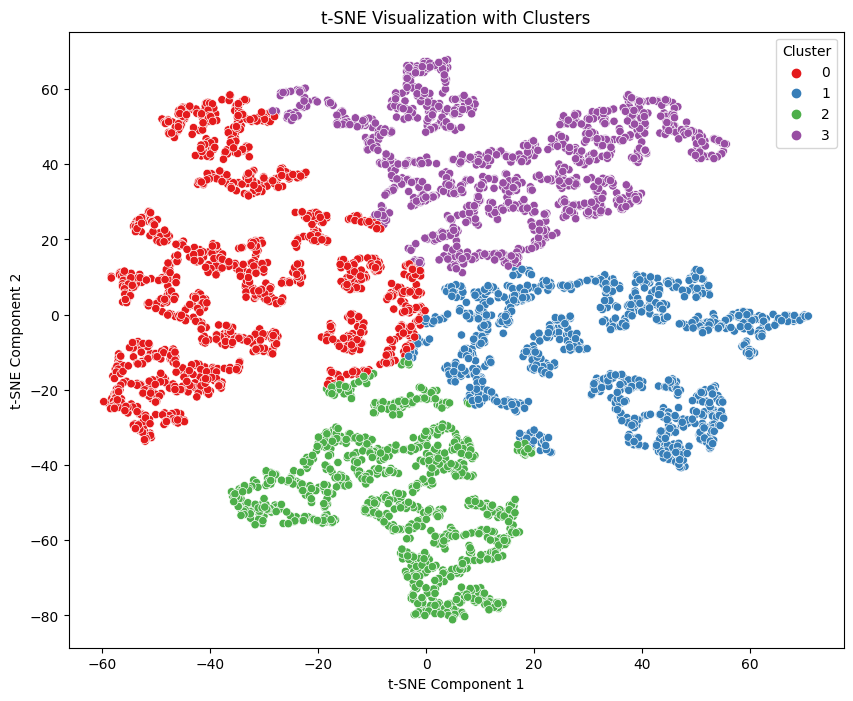

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame containing the t-SNE results and cluster information

# Create a scatter plot of the t-SNE result with cluster coloring
plt.figure(figsize=(10, 8))
sns.scatterplot(x='t-SNE_Component_1', y='t-SNE_Component_2', hue='Cluster', data=df, palette='Set1')
plt.title('t-SNE Visualization with Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster', loc='upper right')
plt.show()

# Step 4: Determining Optimal Number of Clusters

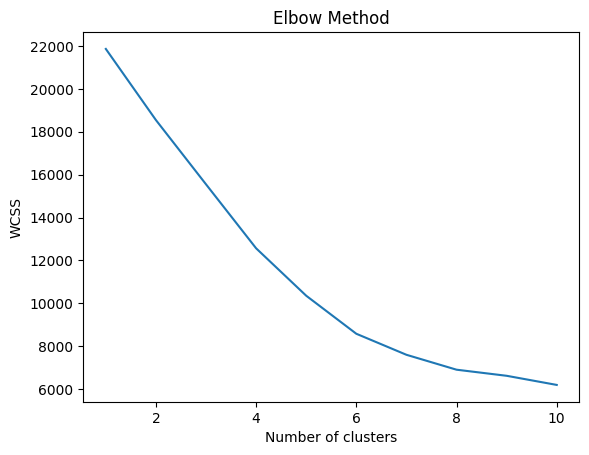

In [36]:
# Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(pca_result)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

For K=2:
  - Silhouette Score: 0.37
  - WCSS: 5855925.50
For K=3:
  - Silhouette Score: 0.39
  - WCSS: 3730077.00
For K=4:
  - Silhouette Score: 0.41
  - WCSS: 2601106.00
For K=5:
  - Silhouette Score: 0.41
  - WCSS: 1993176.38
For K=6:
  - Silhouette Score: 0.44
  - WCSS: 1531228.00
For K=7:
  - Silhouette Score: 0.43
  - WCSS: 1331160.50
For K=8:
  - Silhouette Score: 0.41
  - WCSS: 1152728.25
For K=9:
  - Silhouette Score: 0.42
  - WCSS: 1008362.25
For K=10:
  - Silhouette Score: 0.42
  - WCSS: 877094.50


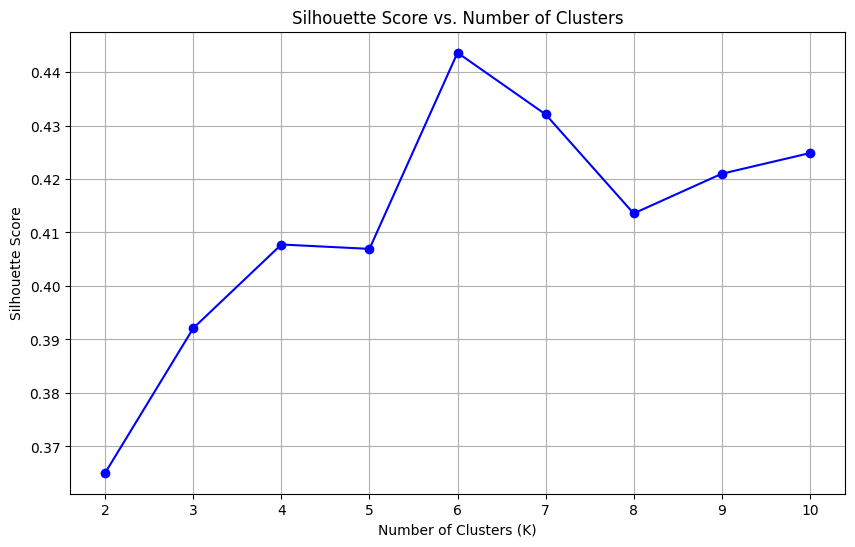

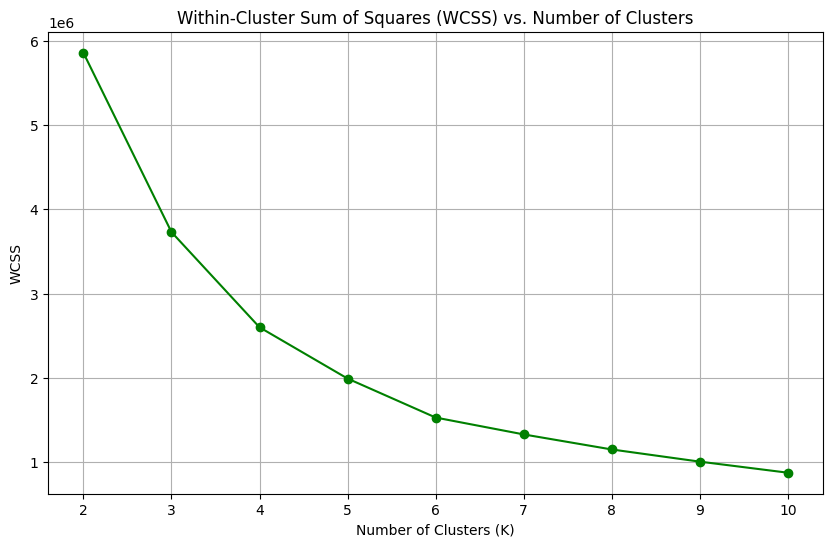

In [52]:
# Create empty lists to store silhouette scores and WCSS
silhouette_scores = []
wcss = []

# Create a range of K values to try
K_range = range(2, 11)

for K in K_range:
    # Fit K-means clustering for each K
    kmeans = KMeans(n_clusters=K, n_init=10, random_state=42)
    kmeans.fit(tsne_result)  # Use t-SNE result for clustering
    
    # Calculate the silhouette score for the current K
    silhouette_avg = silhouette_score(tsne_result, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

    # Calculate the within-cluster sum of squares (WCSS)
    wcss.append(kmeans.inertia_)
    
    print(f"For K={K}:")
    print(f"  - Silhouette Score: {silhouette_avg:.2f}")
    print(f"  - WCSS: {wcss[-1]:.2f}")

# Plot the silhouette scores to visualize the optimal number of clusters
plt.figure(figsize=(10, 6))
plt.plot(K_range, silhouette_scores, marker='o', linestyle='-', color='b')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# Plot the WCSS to find the "elbow point" for choosing K
plt.figure(figsize=(10, 6))
plt.plot(K_range, wcss, marker='o', linestyle='-', color='g')
plt.title('Within-Cluster Sum of Squares (WCSS) vs. Number of Clusters')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

# Step 5: K-means Clustering

In [53]:
# Based on the elbow method, let's choose 4 clusters
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
clusters = kmeans.fit_predict(pca_result)

In [54]:
# Assign cluster labels to the DataFrame
df['Cluster'] = clusters

In [55]:
# Calculate cluster-specific metrics
cluster_metrics = df.groupby('Cluster').agg({
    'Recency': 'mean',            
    'OrderFrequency': 'mean',    
    'TotalSpending': 'mean',     
    'BasketSize': 'mean',        
}).reset_index()

In [56]:
# Rename the columns for clarity
cluster_metrics.columns = ['Cluster', 'AvgRecency', 'AvgPurchaseFrequency', 'AvgSpending', 'AvgBasketSize']

In [57]:
# Print or display the cluster metrics
print(cluster_metrics)

   Cluster  AvgRecency  AvgPurchaseFrequency   AvgSpending  AvgBasketSize
0        0   41.769231              6.697041    235.353680     244.918943
1        1   45.316843              5.048292    144.718210     179.553931
2        2  256.399181              1.770727     41.644944     137.398882
3        3    2.571429             81.428571  19949.988571    1057.829991


In [58]:
distinguishing_characteristics = {}

for cluster in range(len(cluster_metrics)):
    cluster_row = cluster_metrics.iloc[cluster]
    cluster_num = cluster_row['Cluster']
    cluster_name = f"Cluster {int(cluster_num)}"
    
    highest_value_column = cluster_row[1:].idxmax()  
    highest_value = cluster_row[highest_value_column]  
    
    distinguishing_characteristics[cluster_name] = {
        'Characteristic': highest_value_column,
        'HighestValue': highest_value
    }

# Print the distinguishing characteristics for each cluster
for cluster, char_info in distinguishing_characteristics.items():
    print(f"{cluster} has the highest {char_info['Characteristic']} ({char_info['HighestValue']}).")

Cluster 0 has the highest AvgBasketSize (244.9189425993449).
Cluster 1 has the highest AvgBasketSize (179.55393146853407).
Cluster 2 has the highest AvgRecency (256.39918116683725).
Cluster 3 has the highest AvgSpending (19949.988571428574).


In [59]:
# Identify unique features for Cluster 1 compared to other clusters
unique_features = {}

for cluster in range(len(cluster_metrics)):
    if cluster == 1:
        continue  # Skip Cluster 1
        
    cluster_row = cluster_metrics.iloc[cluster]
    cluster_num = cluster_row['Cluster']
    cluster_name = f"Cluster {int(cluster_num)}"
    
    unique_features[cluster_name] = {
        'Recency': cluster_metrics.loc[1, 'AvgRecency'] - cluster_row['AvgRecency'],
        'PurchaseFrequency': cluster_metrics.loc[1, 'AvgPurchaseFrequency'] - cluster_row['AvgPurchaseFrequency'],
        'Spending': cluster_metrics.loc[1, 'AvgSpending'] - cluster_row['AvgSpending'],
        'BasketSize': cluster_metrics.loc[1, 'AvgBasketSize'] - cluster_row['AvgBasketSize']
    }

# Print the unique features for Cluster 1 compared to other clusters
for cluster, unique_info in unique_features.items():
    print(f"{cluster} has unique features compared to Cluster 1:")
    print(f"   -  Recency: {unique_info['Recency']:.2f}")
    print(f"   -  Purchase Frequency: {unique_info['PurchaseFrequency']:.2f}")
    print(f"   -  Spending: {unique_info['Spending']:.2f}")
    print(f"   -  Basket Size: {unique_info['BasketSize']:.2f}")

Cluster 0 has unique features compared to Cluster 1:
   -  Recency: 3.55
   -  Purchase Frequency: -1.65
   -  Spending: -90.64
   -  Basket Size: -65.37
Cluster 2 has unique features compared to Cluster 1:
   -  Recency: -211.08
   -  Purchase Frequency: 3.28
   -  Spending: 103.07
   -  Basket Size: 42.16
Cluster 3 has unique features compared to Cluster 1:
   -  Recency: 42.75
   -  Purchase Frequency: -76.38
   -  Spending: -19805.27
   -  Basket Size: -878.28


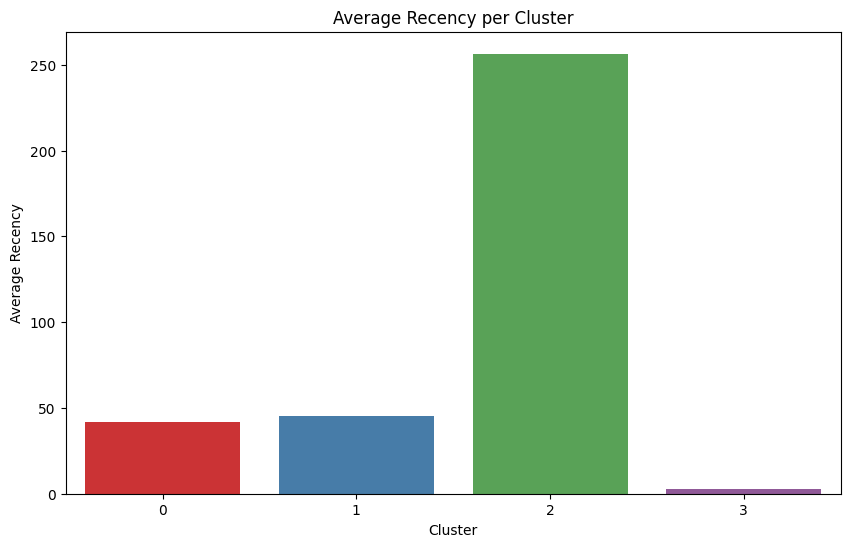

In [73]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='AvgRecency', data=cluster_metrics, palette='Set1')
plt.title('Average Recency per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Recency')
plt.show()

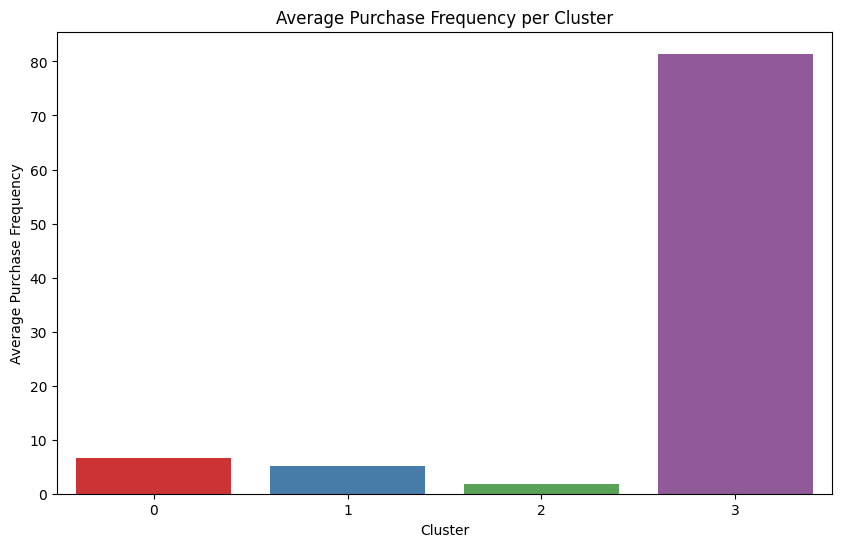

In [74]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='AvgPurchaseFrequency', data=cluster_metrics, palette='Set1')
plt.title('Average Purchase Frequency per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Purchase Frequency')
plt.show()

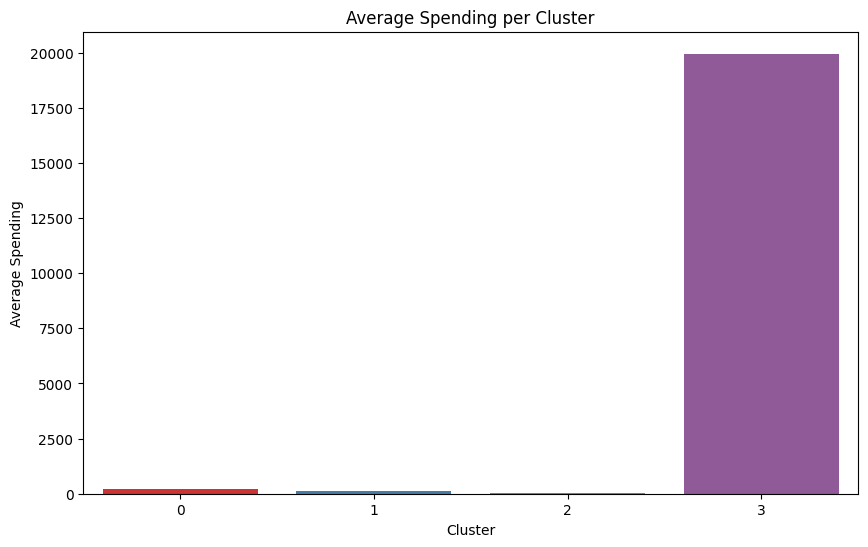

In [75]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='AvgSpending', data=cluster_metrics, palette='Set1')
plt.title('Average Spending per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Spending')
plt.show()

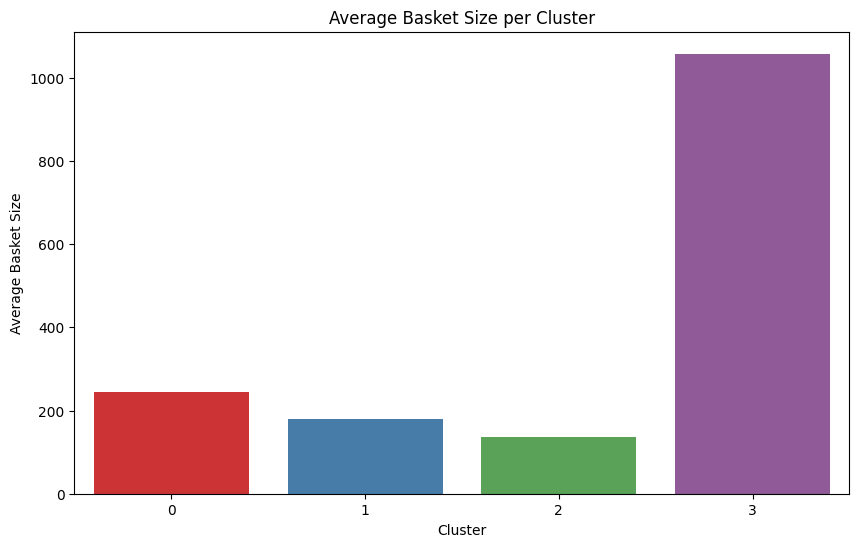

In [76]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='AvgBasketSize', data=cluster_metrics, palette='Set1')
plt.title('Average Basket Size per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Basket Size')
plt.show()

# Step 6: Cluster Profiling

In [77]:
# Assign cluster labels to the DataFrame
df['Cluster'] = clusters

# Calculate cluster profiles
cluster_profiles = df.groupby('Cluster').mean()

In [78]:
# Print the cluster profiles
print(cluster_profiles)

           CustomerID     Recency  OrderFrequency  TotalSpending  BasketSize  \
Cluster                                                                        
0        13788.743316   41.187760        7.107546     326.599988  249.997006   
1        16792.889215   45.287808        4.975967     136.752860  178.725540   
2        15295.083418  255.827060        1.769074      41.554537  137.119404   

         PCA_Component_1  PCA_Component_2  PCA_Component_3  PCA_Component_4  \
Cluster                                                                       
0               0.499810         0.657336        -0.644463         0.009095   
1               0.096977        -0.758371         0.176546         0.588262   
2              -1.024032         0.190726         0.796993        -1.036502   

         PCA_Component_5  t-SNE_Component_1  t-SNE_Component_2  
Cluster                                                         
0               0.097554          16.170748          27.781139  
1       

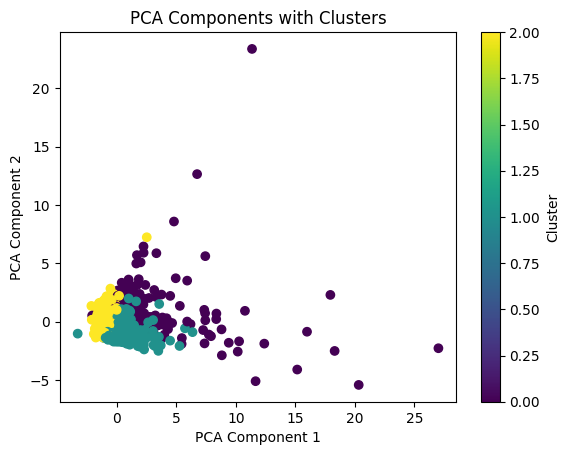

In [79]:
# Step 7: Visualization
plt.scatter(pca_result[:,0], pca_result[:,1], c=clusters, cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Components with Clusters')
plt.colorbar(label='Cluster')
plt.show()

# Step 8: Evaluation

In [80]:
silhouette_avg = silhouette_score(pca_result, clusters)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.3228930597351984


# Step 9: Personalization and Recommendations

In [81]:
pip install schedule

Note: you may need to restart the kernel to use updated packages.


In [82]:
import smtplib
import schedule
import time
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText

# Define a function to suggest products for each customer
def suggest_products(customer):
    return ["Product1", "Product2", "Product3"]

# Define a function to send personalized recommendation emails
def send_recommendation_email(customer):
    # Get customer information
    customer_id = customer['CustomerID']
    #customer_email = customer['Email']  

    # Generate product recommendations for the customer
    recommended_products = suggest_products(customer)

# Schedule the email sending task to run once a week on Friday night
def schedule_email_task():
    # Schedule the task to run at Friday night
    schedule.every().friday.at("20:00").do(send_recommendation_emails)
